In [1]:
import pandas as pd
import wget
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import norm
from scipy.stats import binned_statistic

%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# READ DATA

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/forest-fires/forestfires.csv'
filename = wget.download(url)
df = pd.read_csv(filename)
df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [3]:
train=df.sample(frac=0.8,random_state=200) #random state is a seed value
test=df.drop(train.index)

#  EDA

In [4]:
print(train.shape)
print(test.shape)

(414, 13)
(103, 13)


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 414 entries, 396 to 27
Data columns (total 13 columns):
X        414 non-null int64
Y        414 non-null int64
month    414 non-null object
day      414 non-null object
FFMC     414 non-null float64
DMC      414 non-null float64
DC       414 non-null float64
ISI      414 non-null float64
temp     414 non-null float64
RH       414 non-null int64
wind     414 non-null float64
rain     414 non-null float64
area     414 non-null float64
dtypes: float64(8), int64(3), object(2)
memory usage: 45.3+ KB


In [6]:
train['area'].describe()

count    414.000000
mean      11.438237
std       46.319820
min        0.000000
25%        0.000000
50%        0.225000
75%        6.375000
max      746.280000
Name: area, dtype: float64

## Categorical Columns Correlation

In [7]:
train.groupby('month')['area'].size().sort_values(ascending=False)

month
aug    146
sep    137
mar     43
jul     25
jun     17
feb     16
oct     11
dec      7
apr      7
may      2
jan      2
nov      1
Name: area, dtype: int64

In [8]:
train.groupby('day')['area'].size().sort_values(ascending=False)

day
sat    70
fri    70
sun    69
mon    58
thu    52
tue    50
wed    45
Name: area, dtype: int64

Day seems not to be an important indicator, however, month has more significant influence at least on the frequecy of the fires. Therefore, day column will be dropped along with may, jan, and nov rows as they are outliers.

In [9]:
train_idx = train.set_index('month')
train_cat = train_idx.drop(['may', 'jan', 'nov']).drop('day', axis=1)
train_cat = train_cat.reset_index()
train_cat.head()

,month,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,sep,4,3,90.5,96.7,750.5,11.4,20.4,55,4.9,0.0,3.64
1,aug,4,3,94.2,117.2,581.1,11.0,21.4,44,2.7,0.0,0.68
2,jun,7,4,94.3,96.3,200.0,56.1,21.0,44,4.5,0.0,0.00
3,aug,6,5,95.2,131.7,578.8,10.4,27.4,22,4.0,0.0,0.90
4,sep,7,4,91.6,108.4,764.0,6.2,19.3,44,2.2,0.0,0.00


## Numeric Columns Correlation

In [10]:
train_corr = train.corr()['area'].sort_values(ascending=False)
train_corr

area    1.000000
DMC     0.120821
temp    0.102162
X       0.076321
DC      0.054142
FFMC    0.047944
Y       0.033424
ISI     0.028935
wind    0.027180
rain   -0.021945
RH     -0.057199
Name: area, dtype: float64

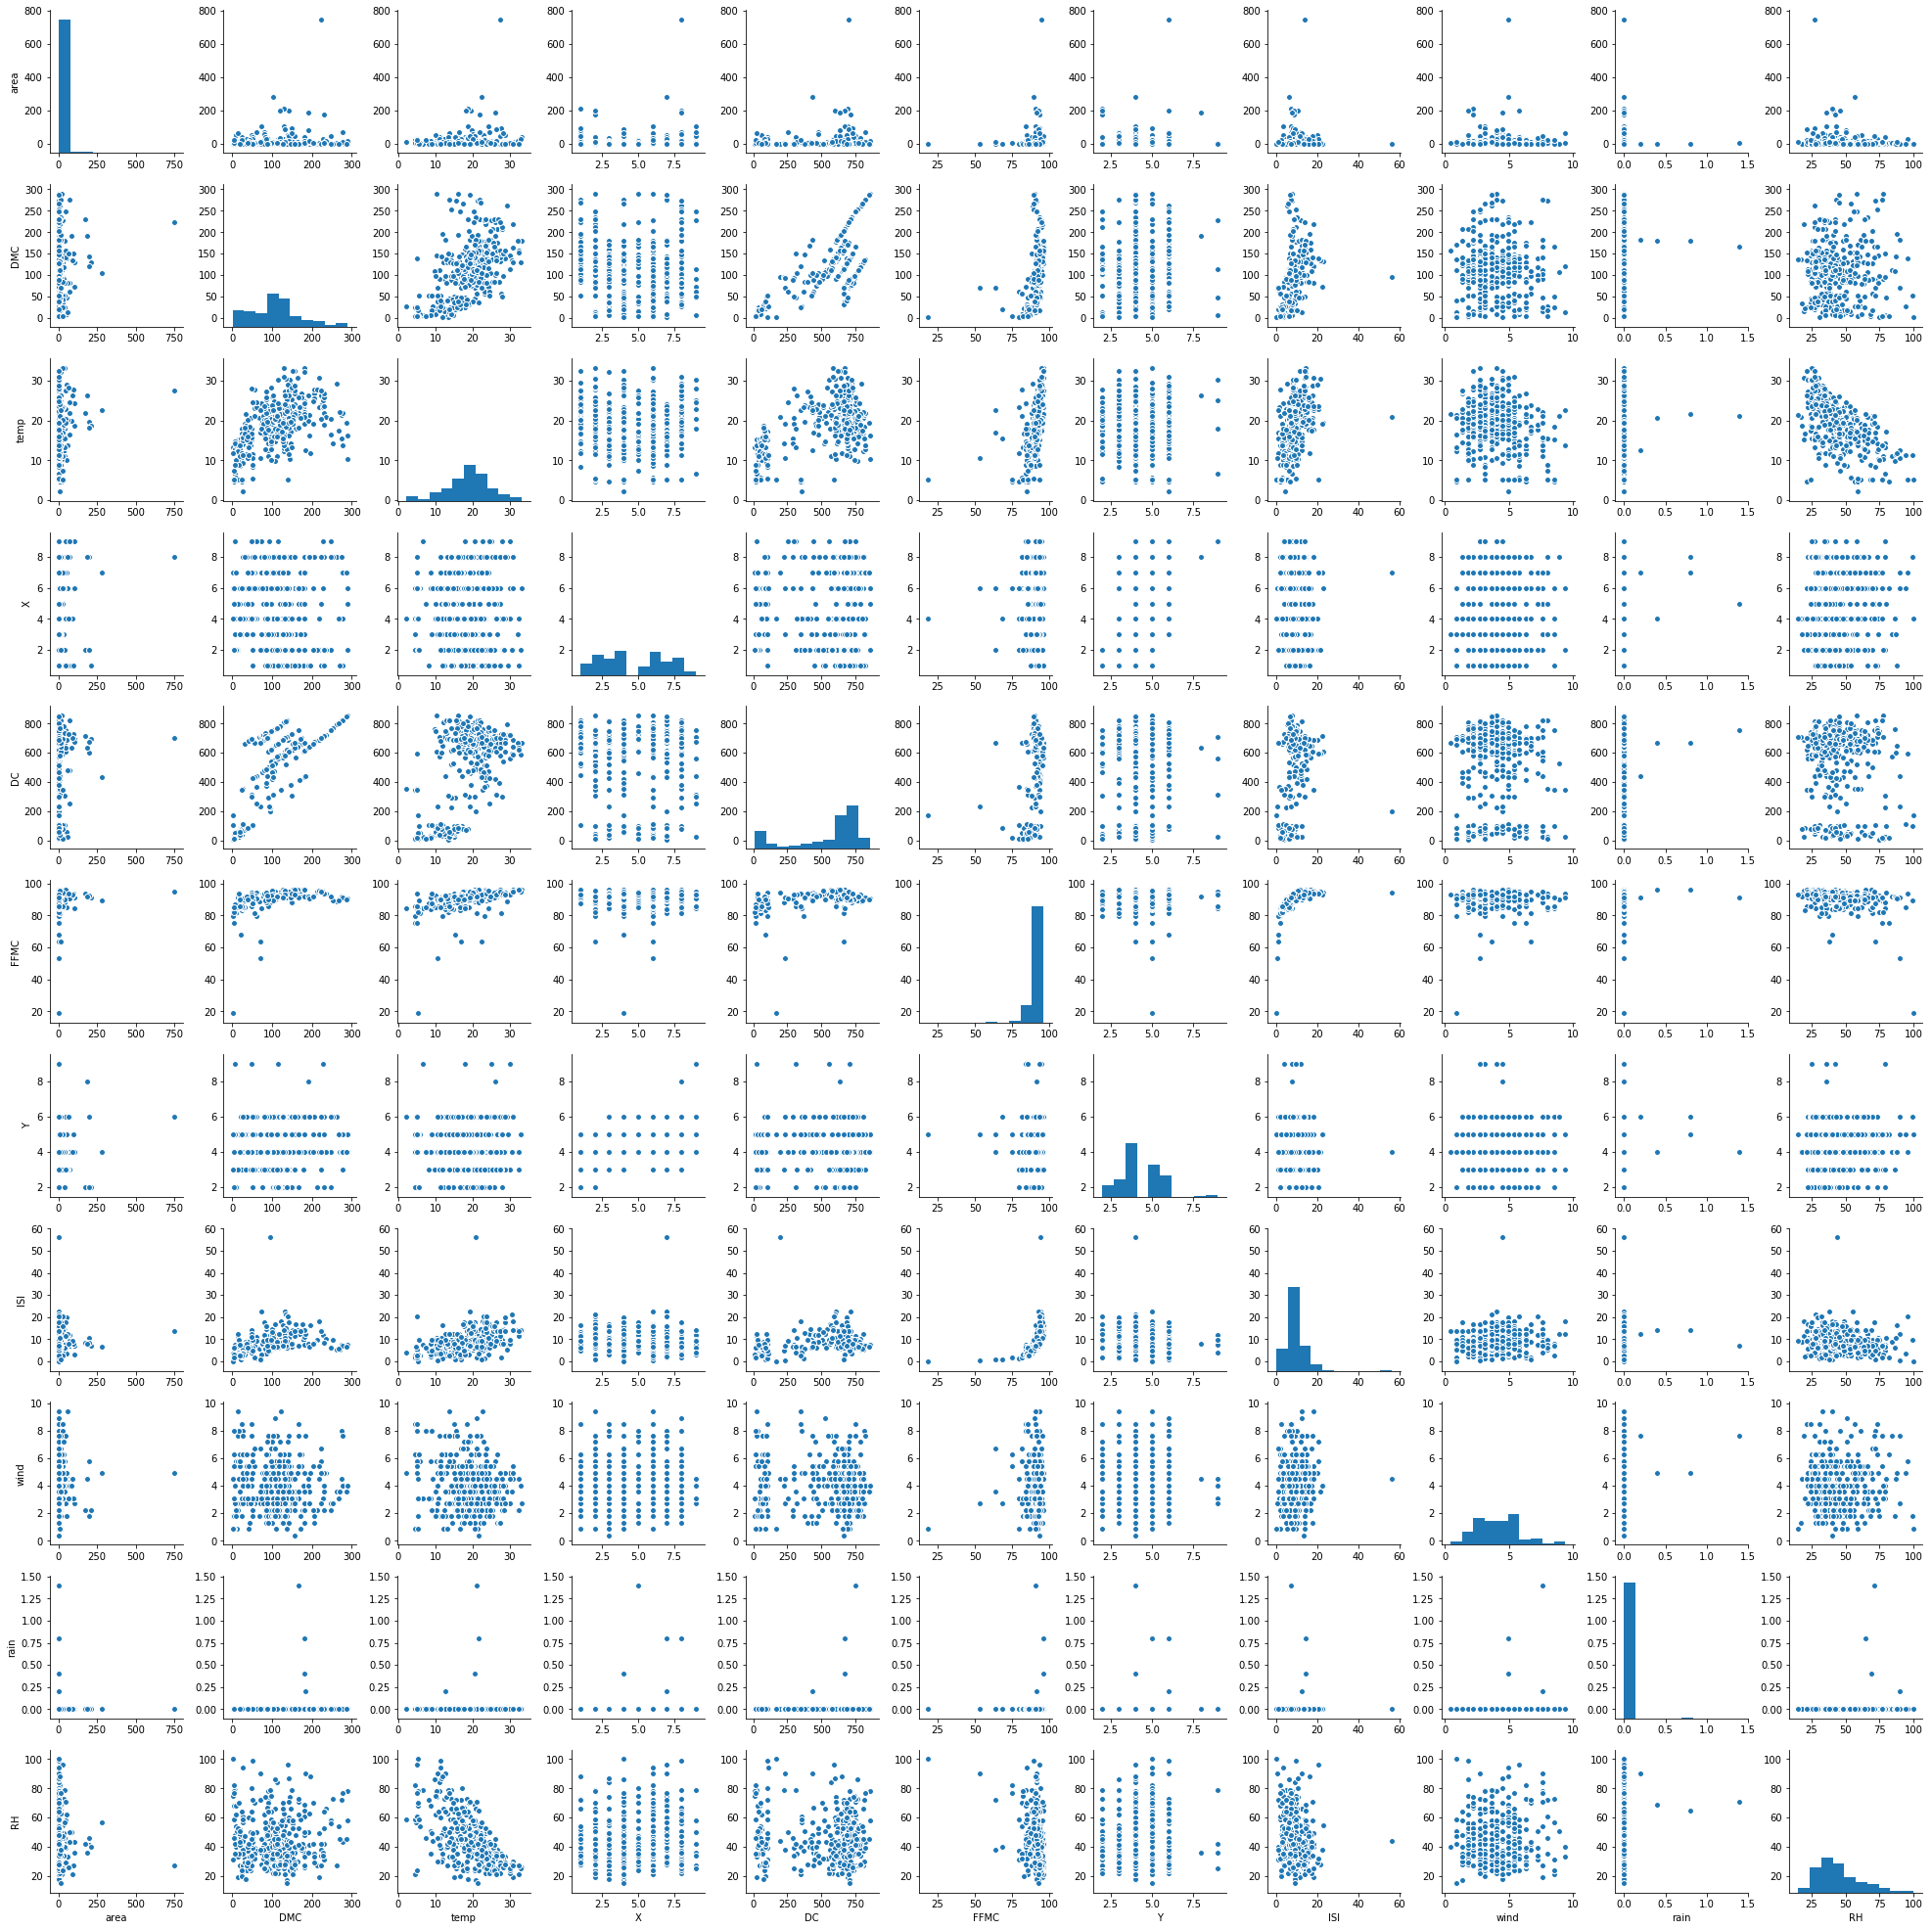

In [11]:
train_num_cols = train_corr.index.tolist()
train_num = train[train_num_cols]
sns.pairplot(train_num)

As it's seen in the plot, there are some outliers in the FFMC, ISI and area columns. So, the're going to be dropped.

In [12]:
print(train_num[(train_num['FFMC'] < 40) & (train_num['area'] < 100)].index.tolist())
print(train_num[(train_num['ISI'] > 40) & (train_num['area'] < 100)].index.tolist())
print(train_num[(train_num['area'] > 250)].index.tolist())

[379]
[22]
[479, 415]


In [13]:
train_num = train_num.drop([379, 22, 415, 479])

In [14]:
print(train_num.shape)
print(train_cat.shape)

(410, 11)
(409, 12)


In [15]:
train_join = train_num.merge(train_cat, how='inner', on=train_num_cols)
train_join.shape

(410, 12)

# Feature Engineering

In [16]:
train_final = pd.get_dummies(train_join, columns=['month'])
train_final.columns = train_final.columns.str.replace('month_', '')
train_final.columns

Index(['area', 'DMC', 'temp', 'X', 'DC', 'FFMC', 'Y', 'ISI', 'wind', 'rain', 'RH', 'apr', 'aug', 'dec', 'feb', 'jul', 'jun', 'mar', 'oct', 'sep'], dtype='object')

In [17]:
train_final['area_cat'] = pd.cut(train_final['area'], bins=[0, 1, 10, 50, 100, 200, 700], include_lowest=True, 
                                 labels=['0-1', '1-10', '10-50', '50-100', '100-200', '>250'])
train_final.area_cat.value_counts()

0-1        225
1-10       108
10-50       60
50-100      10
100-200      5
>250         2
Name: area_cat, dtype: int64

In [18]:
train_final.head()

,area,DMC,temp,X,DC,FFMC,Y,ISI,wind,rain,RH,apr,aug,dec,feb,jul,jun,mar,oct,sep,area_cat
0,3.64,96.7,20.4,4,750.5,90.5,3,11.4,4.9,0.0,55,0,0,0,0,0,0,0,0,1,1-10
1,0.68,117.2,21.4,4,581.1,94.2,3,11.0,2.7,0.0,44,0,1,0,0,0,0,0,0,0,0-1
2,0.90,131.7,27.4,6,578.8,95.2,5,10.4,4.0,0.0,22,0,1,0,0,0,0,0,0,0,0-1
3,0.00,108.4,19.3,7,764.0,91.6,4,6.2,2.2,0.0,44,0,0,0,0,0,0,0,0,1,0-1
4,6.30,263.1,29.3,8,795.9,88.9,6,5.2,3.6,0.0,27,0,0,0,0,1,0,0,0,0,1-10


Note: Although area_cat column has created for creating classification models, it was never used to accomplish the purpose. It's on the TODO list. The objective was to classify the area based on the category and use it as an input and predict the actual value of the area.

# Feature Importance


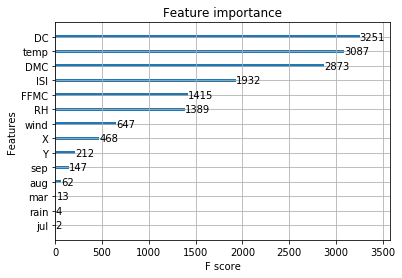

In [19]:
from xgboost import XGBClassifier, plot_importance
model = XGBClassifier()
train_final_cols = train_final.columns[:-1].tolist()
model.fit(train_final[train_final.columns[1:-1].tolist()], train_final[train_final_cols].area)
plot_importance(model, max_num_features = 15)
plt.show()

In [20]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import RFE

X = train_final.drop(['area', 'area_cat'], axis=1)
y = train_final['area']

extraTreesRegressor = ExtraTreesRegressor()
rfe = RFE(extraTreesRegressor, 15)
fit = rfe.fit(X,y)
xgboost_cols = X.columns[fit.support_]

print("The number of features:", fit.n_features_)
print("Selected Features:", xgboost_cols)
print("Feature Rankings:", fit.ranking_)


The number of features: 15
Selected Features: Index(['DMC', 'temp', 'X', 'DC', 'FFMC', 'Y', 'ISI', 'wind', 'RH', 'apr', 'aug', 'jul', 'jun', 'oct', 'sep'], dtype='object')
Feature Rankings: [1 1 1 1 1 1 1 1 5 1 1 1 3 2 1 1 4 1 1]


In [21]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest, f_regression

X = train_final.drop(['area', 'area_cat'], axis=1)
y = train_final['area']

# feature extraction
test = SelectKBest(score_func=f_regression, k=7)
fit = test.fit(X, y)
               
# summarize scores
set_printoptions(precision=3)
print(fit.scores_)
print(fit.get_support(indices=True))
print(X.columns[fit.get_support(indices=True)])


[  3.463e+00   1.533e+00   6.027e-02   1.463e+00   5.511e-01   3.891e-01
   1.312e-03   4.012e-04   3.888e-01   8.618e-01   6.396e-03   9.545e-02
   1.794e-01   1.170e-01   1.358e+00   3.622e-01   1.313e+00   3.346e-05
   1.669e+00]
[ 0  1  3  9 14 16 18]
Index(['DMC', 'temp', 'DC', 'RH', 'jul', 'mar', 'sep'], dtype='object')


Based on the XGBClassifier and SelectKBest, the most important features are DMC and temp. Nonetheless, XGBoost features are performing slighthly better on the models. Therefore, train_final is going to have only XGBoost features.

# Models

In [22]:
X = train_final[xgboost_cols] 
y = train_final['area']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3 , random_state = 0)

### Linear Regression

MAE for Linear Regression Model in sklearn: 16.32


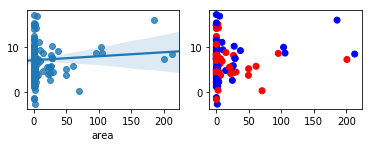

In [23]:
from sklearn.linear_model import LinearRegression
from sklearn import metrics

lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)

mae = metrics.mean_absolute_error(y_test, y_pred)

plt.subplot(2,2,1)
sns.regplot(y_test, y_pred)
plt.subplot(2,2,2)
plt.scatter(y_test,y_pred, c=['r','b'])
print("MAE for Linear Regression Model in sklearn: %.2f" % mae)

### Support Vector Regression


In [24]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error as mae

svr = SVR(kernel='rbf')
y_pred = cross_val_predict(svr, X, y, cv=10)
accuracy = mae(y, y_pred)

print("MAE for Support Vector Regressor in sklearn: %.2f" % accuracy)

MAE for Support Vector Regressor in sklearn: 9.11


### Random Forest Regressor

In [25]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

def rfr_model(X, y):
# Perform Grid-Search
    gsc = GridSearchCV(estimator=RandomForestRegressor(), param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000)},
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], 
                                random_state=False, verbose=False)

    return rfr

rfr = rfr_model(X, y)
predictions = cross_val_predict(rfr, X, y, cv=10)
acc = mae(y, predictions)

print("MAE for Random Forest Regressor in sklearn: %.2f" % acc)

MAE for Random Forest Regressor in sklearn: 13.11
